<a href="https://colab.research.google.com/github/skytecat/DLS/blob/main/hw_6_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


# Шаг 1. Загрузка и подготовка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>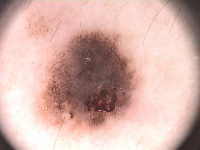</td><td>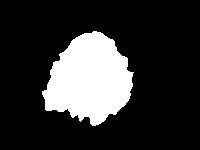</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=ad5dce3a-4e24-436a-8f13-6613e00e79ef
To: /content/PH2Dataset.rar
100% 162M/162M [00:01<00:00, 101MB/s]


In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [1]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [2]:
from skimage.transform import resize
size = (256, 256)
'''
mode='constant' — способ заполнения пикселей за пределами границы исходного изображения (обычно используется константное значение, например, 0)
anti_aliasing=True — включает сглаживание, что помогает уменьшить появление артефактов (ступенчатости) при уменьшении размера изображения, особенно полезно для изображений, содержащих текстуры или детали
'''
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
'''
anti_aliasing=False — сглаживание отключено. Это критично, потому что маски часто являются бинарными (0 или 1) или категориальными. Включение антиалиасинга могло бы "размазать" границы между классами, создавая промежуточные значения (например, 0.3, 0.7), что исказит истинную разметку
> 0.5 — применяется пороговое преобразование к каждому измененному размеру маски. Все пиксели, значение которых после изменения размера больше 0.5, становятся True (1), остальные — False (0). Это превращает потенциально вероятностную (непрерывную) маску в бинарную.
'''
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

Как работает **resize**:

Функция *resize* интерполирует значения пикселей, чтобы заполнить новую сетку изображения нужного размера. метод интерполяции по умолчанию — линейная интерполяция (bilinear), если не указано иное. Это означает, что значения новых пикселей вычисляются как взвешенное среднее соседних пикселей старого изображения

**Пример:**\
Представим, что у нас есть бинарная маска 2x2:
$$
\begin {bmatrix}
0 & 1\\
1 & 0
\end {bmatrix}
$$

Мы хотим изменить её размер до 3x3. При линейной интерполяции новые пиксели будут вычисляться на основе соседей:
$$
\begin {bmatrix}
0.0 & 0.5 & 1.0\\
0.5 & 0.5 & 0.5\\
1.0 & 0.5 & 0.0
\end {bmatrix}
$$

In [3]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

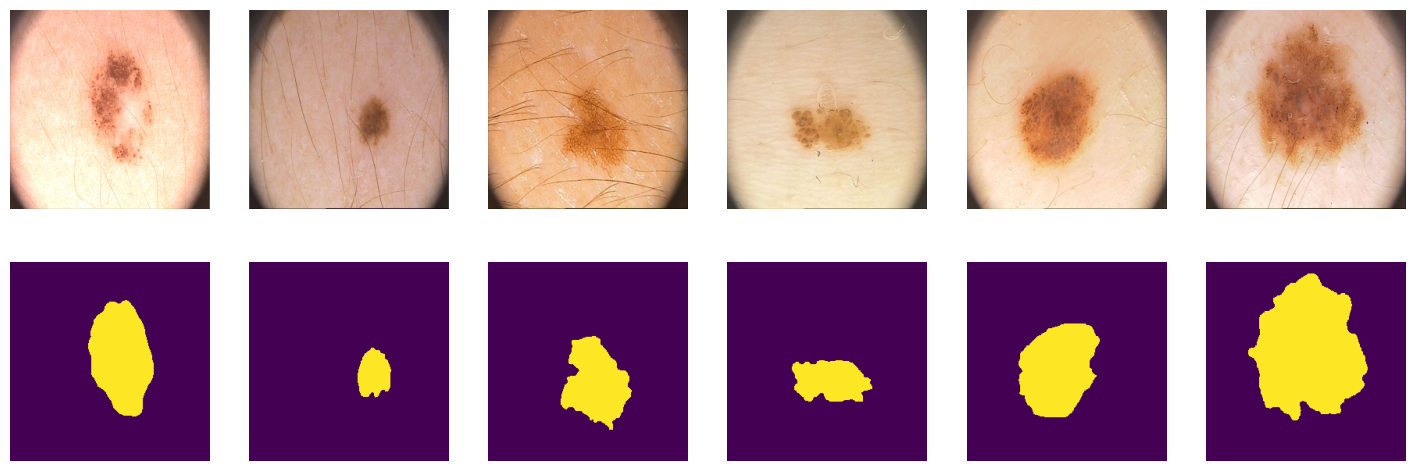

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [5]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [6]:
from torch.utils.data import DataLoader
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=False)

In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Шаг 2. Метрика качества модели

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

In [10]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.8 MB/s eta 0:00:00


In [8]:
from torchmetrics import JaccardIndex

iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

# Задания: Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## Шаг 3. Loss функция - BCE [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

1. Подставим определение сигмоиды:
   $$
   \sigma(\hat{y}) = \frac{1}{1 + e^{-\hat{y}}}
   \Rightarrow
   \log \sigma(\hat{y}) = -\log(1 + e^{-\hat{y}})
   $$
   $$
   1 - \sigma(\hat{y}) = \frac{e^{-\hat{y}}}{1 + e^{-\hat{y}}}
   \Rightarrow
   \log(1 - \sigma(\hat{y})) = -\hat{y} - \log(1 + e^{-\hat{y}})
   $$

2. Подставим в [1], раскроем скобки:
   $$
   \mathcal{L} = - \left[ y \cdot (-\log(1 + e^{-\hat{y}})) + (1 - y)(-\hat{y} - \log(1 + e^{-\hat{y}})) \right]
   $$
   $$
   = y \log(1 + e^{-\hat{y}}) + (1 - y)\hat{y} + (1 - y)\log(1 + e^{-\hat{y}})
   $$
   $$
   = \log(1 + e^{-\hat{y}}) + (1 - y)\hat{y}
   $$
   $$
   = \hat{y} - y\hat{y} + \log(1 + e^{-\hat{y}})
   $$

$$
\boxed{
\mathcal{L}_{\text{BCE}}(y, \hat{y}) = \hat{y} - y\hat{y} + \log(1 + e^{-\hat{y}})
}
$$

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [ ]:
def bce_loss(y_pred, y_real):
  y_pred, y_real = y_pred.numpy(), y_real.numpy()
  sigmoid = 1 / (1 + np.exp(-y_pred))
  res = y_real * np.log(sigmoid) + (1-y_real)*np.log(1 - sigmoid)
  return -res.sum()

def bce_true(y_pred, y_real):
  y_pred, y_real = y_pred.numpy(), y_real.numpy()
  res = y_pred - y_pred * y_real + np.log(1 + np.exp(-y_pred))
  return res.sum()

Проверим корректность работы на простом примере

In [ ]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss             = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный                = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch              = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch  = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss             = 4.312084674835205
BCE loss честно посчитанный                = 4.312084197998047
BCE loss from torch bce_torch              = 4.312084674835205
BCE loss from torch with logits bce_torch  = 4.312084674835205


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss            = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный               = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch             = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss            = 12.33568201214075
BCE loss честно посчитанный               = 12.335682146251202
BCE loss from torch bce_torch             = 12.335681915283203
BCE loss from torch with logits bce_torch = 12.335681915283203


In [ ]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [13]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 5.07MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 186kB/s]
Download completed


In [10]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

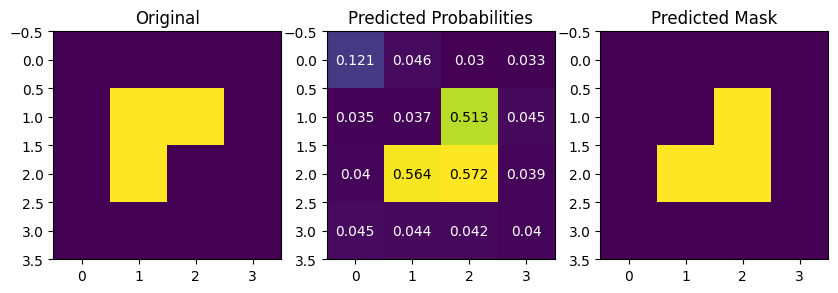

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [ ]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## Шаг 4. Модель SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

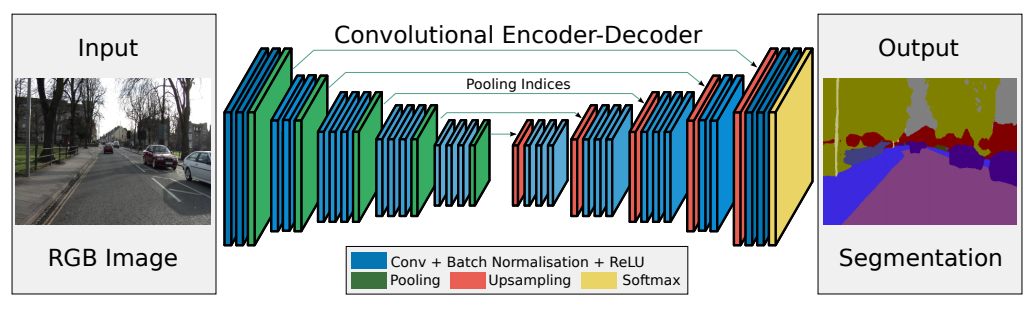

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки. Для этого скачаем и изучим feature extractor VGG-16, который лежит в основе SegNet.

In [ ]:
model_vgg16 = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 127MB/s]


In [ ]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Feature extractor VGG-16 состоит из 5 блоков:
- два блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d
- три блока со структурой:
Conv2d -> ReLU -> Conv2d -> ReLU -> Conv2d -> ReLU -> MaxPool2d

В первом блоке - на входе три канала (по числу каналов в изображениях), которые конволюционный слой преобразует в 64 канала.

Во втором, третьем и четвертом блоках первый конволюционный слой удваивает количество каналов, а последующие конволюционные слои не меняют количество каналов.

В последнем блоке число каналов от слоя к слою не меняется.

Теперь напишем код одного блока энкодера нашей модели SegNet.  

In [12]:
# Параметрами блока будут:
# - количество каналов на входе
# - количество каналов на выходе
# - глубина блока (2 или 3, по количеству конволюционных слоев)
# - kernel_size и padding
#
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1):
        super(EncoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
        self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
        # дальше реализуем то, что на картинке выше обозначено Conv + Batch Normalization + ReLU
        self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
        self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.ReLU(inplace=True))

        # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
        for i in range(depth-1):
            self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

        self.maxpooling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) #добавляем MaxPool с индексами для последующего Unpooling

    # Обратите внимание: на вход метод forward() получает карту признаков (х),
    # а возвращает карту признаков и индексы для последующего Unpooling
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x, indices = self.maxpooling(x)
        return x, indices


По аналогии напишите код одного блока декодера.

К карте признаков на входе каждого блока примеяется nn.MaxUnpool2d с индексами из симметричного блока энкодера. Затем повторяется связка Conv + Batch Normalization + ReLU. Количество каналов меняется зеркально блокам энкодера:
- в первом блоке декодера количество каналов не меняется
- во 2-4 блоках декодера количество каналов уменьшается в 2 раза после прохождения последнего конволюционного слоя
- на выходе из последнего блока декодера 1 канал

Обратите внимание, что после последней конволюции последнего блока декодера не применяется батч-нормализация и функция активации.

In [13]:
class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth, kernel_size = 3, padding = 1, is_last_block=False):
      super(DecoderBlock, self).__init__() # инициируем экземляр класса, наследующего от nn.Module
      self.layers = nn.ModuleList() # в self.layers будем добавлять слои блока
      self.layers.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
      self.layers.append(nn.BatchNorm2d(out_channels))
      self.layers.append(nn.ReLU(inplace=True))

      # цикл for помогает использовать один код для блоков как с глубиной 2, так и с глубиной 3
      for i in range(depth-1):
          self.layers.append(nn.Conv2d(in_channels = out_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding))
          if not is_last_block:
            self.layers.append(nn.BatchNorm2d(out_channels))
            self.layers.append(nn.ReLU(inplace=True))

      self.maxunpooling = nn.MaxUnpool2d(kernel_size=2, stride=2) #добавляем MaxPool с индексами для последующего Unpooling

  def forward(self, x, indices):
      x = self.maxunpooling(x, indices=indices)
      for layer in self.layers:
          x = layer(x)
      return x

Соединим блоки энкодера и декодера в модель SegNet:

In [14]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels = 1, num_features = 64) -> None:
        super(SegNet, self).__init__()

        # Encoder
        self.encoder0 = EncoderBlock(in_channels, num_features, depth=2) # 3->64
        self.encoder1 = EncoderBlock(num_features, num_features * 2, depth=2) # 64->128
        self.encoder2 = EncoderBlock(num_features * 2, num_features * 4, depth=3) # 128->256
        self.encoder3 = EncoderBlock(num_features * 4, num_features * 8, depth=3) # 256->512

        # Encoder bottleneck - количество каналов на входе и на выходе одинаково
        self.encoder4 = EncoderBlock(num_features * 8, num_features * 8, depth=3) # 512->512

        # Decoder bottleneck
        self.decoder0 = DecoderBlock(num_features * 8, num_features * 8, depth=3) # 512->512

        # Decoder
        self.decoder1 = DecoderBlock(num_features * 8, num_features * 4, depth=3) # 512->256
        self.decoder2 = DecoderBlock(num_features * 4, num_features * 2, depth=3) # 256->128
        self.decoder3 = DecoderBlock(num_features * 2, num_features, depth=2) # 128->64
        self.decoder4 = DecoderBlock(num_features, out_channels, depth=2, is_last_block=True) # 64->1

    def forward(self, x):
        # encoder
        x, indices0 = self.encoder0(x)
        x, indices1 = self.encoder1(x)
        x, indices2 = self.encoder2(x)
        x, indices3 = self.encoder3(x)
        x, indices4 = self.encoder4(x)

        # decoder
        x = self.decoder0(x, indices4)
        x = self.decoder1(x, indices3)
        x = self.decoder2(x, indices2)
        x = self.decoder3(x, indices1)
        output = self.decoder4(x, indices0)
        return output  # no activation

In [ ]:
# Быстрый тест на размер выхода модели

# Создаём модель
model = SegNet(in_channels=3, out_channels=1, num_features=64)

# Тестовый вход: batch=1, channels=3, height=256, width=256
x = torch.randn(1, 3, 256, 256)

# Прямой проход
with torch.no_grad():
    output = model(x)

# Выводим формы
print("Input shape:  ", x.shape)
print("Output shape: ", output.shape)

# Проверка: должен быть (1, 1, 256, 256)
assert output.shape == (1, 1, 256, 256), f"Expected (1, 1, 256, 256), got {output.shape}"
print("Тест пройден: выход имеет правильную форму!")

Input shape:   torch.Size([1, 3, 256, 256])
Output shape:  torch.Size([1, 1, 256, 256])
Тест пройден: выход имеет правильную форму!


## Шаг 5. Тренировка модели [1 балл]

Напишите функции для обучения модели.

In [15]:
from tqdm.notebook import tqdm

In [16]:
def train_one_epoch(model, dataloader, optimizer, device, loss_func):
    model.train()
    total_loss = 0.0
    num_batches = len(dataloader)

    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    for batch in progress_bar:
        images, masks = batch
        images = images.float().to(device)
        masks = masks.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = loss_func(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Loss": loss.item()})

    avg_loss = total_loss / num_batches
    return avg_loss

def validate(model, dataloader, device, loss_func):
    model.eval()
    total_loss = 0.0
    num_batches = len(dataloader)

    with torch.no_grad():
        for batch in dataloader:
            images, masks = batch
            images = images.float().to(device)
            masks = masks.float().to(device)

            outputs = model(images)
            loss = loss_func(outputs, masks)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [17]:
from IPython.display import clear_output

def train(model, train_loader, valid_loader, optimizer, device, loss_func, num_epochs=20, patience=5, best_model_path="best_segnet.pth"):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # === Обучение и валидация ===
        avg_train_loss = train_one_epoch(model, train_loader, optimizer, device, loss_func)
        avg_val_loss = validate(model, valid_loader, device, loss_func)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # === Early stopping ===
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1

        # === Очищаем ВЕСЬ вывод (включая предыдущие графики и логи) ===
        clear_output(wait=True)

        # === Рисуем ГРАФИК ===
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
        plt.plot(val_losses, label='Validation Loss', marker='o', color='orange')
        plt.title(f'Training Progress — Epoch {epoch+1}/{num_epochs}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # === Выводим лог ПОСЛЕ графика ===
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.6f} | "
              f"Val Loss: {avg_val_loss:.6f} | "
              f"Best Val Loss: {best_val_loss:.6f}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

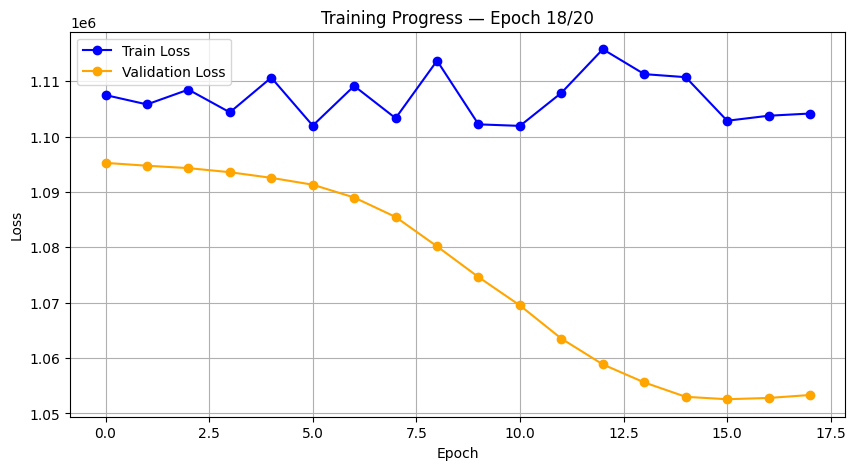

Epoch 18/20 | Train Loss: 1104153.531250 | Val Loss: 1053336.312500 | Best Val Loss: 1052572.937500
Early stopping triggered.


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
loss_fn = nn.BCEWithLogitsLoss(reduction='sum')

train_losses, val_losses = train(
    model=model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    optimizer=optimizer,
    device=device,
    loss_func=loss_fn,
    num_epochs=20,
    patience=2
)

## Шаг 6. Инференс [1 балл]

После обучения модели напишите функцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [20]:
def test(model, test_loader, device, loss_func, checkpoint_path="best_segnet.pth"):
    # Загружаем лучшие веса
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval()
    iou_metric = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(test_loader, desc="Testing"):
            images = images.to(device).float()
            masks = masks.to(device).float()

            outputs = model(images)
            loss = loss_func(outputs, masks)
            total_loss += loss.item()
            # Применяем сигмоиду и вычисляем IoU
            probs = torch.sigmoid(outputs)
            iou = iou_metric(probs, masks)
            total_iou += iou.item()

    avg_test_loss = total_loss / len(test_loader)
    avg_test_iou = total_iou / len(test_loader)
    return avg_test_loss, avg_test_iou

In [21]:
model = SegNet(in_channels=3, out_channels=1)

# Запускаем тест
test_loss, test_iou = test(model, test_dataloader, device, loss_func=nn.BCEWithLogitsLoss(reduction='sum'))
print(f"Test Loss: {test_loss:.6f}")
print(f"Test IOU: {test_iou:.6f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 1119378.125000
Test IOU: 0.051121


В предыдущем эксперименте мы обучали модель с **nn.BCEWithLogitsLoss(reduction='sum')**. Однако такой подход привёл к следующим проблемам:

- Значения функции потерь оказались чрезвычайно высокими (порядка 10^6), что затруднило интерпретацию и стабильность обучения
- Необходимость использовать очень малый learning rate привела к крайне медленной сходимости, модель практически не обучалась за 18 эпох
- Качество сегментации оказалось низким (Test IoU ~ 0.05)

Это связано с тем, что при reduction='sum' лосс суммируется по всем пикселям всех изображений в батче, и его масштаб напрямую зависит от разрешения входных данных и размера батча. В результате градиенты становятся слишком большими.

В отличие от этого, **reduction='mean'** вычисляет средний лосс на один пиксель, что:

- Обеспечивает стабильный и интерпретируемый масштаб лосса
- Позволяет использовать стандартные значения learning rate
- Ускоряет сходимость и улучшает качество модели

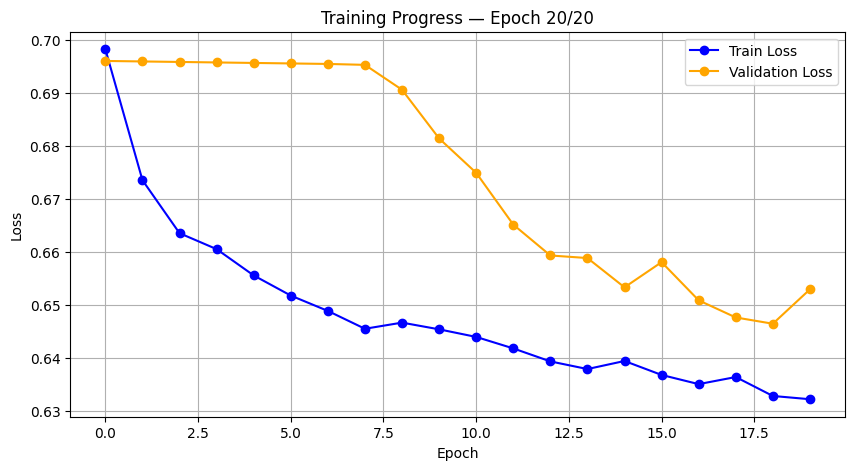

Epoch 20/20 | Train Loss: 0.632186 | Val Loss: 0.652908 | Best Val Loss: 0.646422


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean')

train_losses, val_losses = train(
    model=model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    optimizer=optimizer,
    device=device,
    loss_func=loss_fn,
    num_epochs=20,
    patience=2,
    best_model_path="best_segnet_mean.pth"
)

In [31]:
model = SegNet(in_channels=3, out_channels=1)

# Запускаем тест
test_loss, test_iou = test(model, test_dataloader, device, loss_func=nn.BCEWithLogitsLoss(reduction='mean'), checkpoint_path="best_segnet_mean.pth")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test IOU: {test_iou:.6f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.622742
Test IOU: 0.376426


В первом эксперименте модель, обученная с использованием стандартного BCEWithLogitsLoss (reduction='mean') и learning rate 1e-4, достигла Test IoU ~ 0.72, что является хорошим результатом для архитектуры SegNet на задаче сегментации.

Однако при повторном обучении с идентичными настройками качество существенно ухудшилось (Test IoU ~ 0.38).

**Возможное объяснения этого расхождения:**

Удачная инициализация весов в первом запуске

Нейронные сети инициализируются случайными весами. В некоторых случаях такая инициализация может быть особенно удачной и позволить модели быстро сойтись к хорошему локальному минимуму. Это особенно вероятно, учитывая наш небольшой объём обучающих данных.

Есть еще проблема отсутствия фиксации случайных seed`ов
Без явной установки np.random.seed() результаты не воспроизводимы от запуска к запуску, что затрудняет честное сравнение

In [28]:
model = SegNet(in_channels=3, out_channels=1)

# Запускаем тест
test_loss, test_iou = test(model, test_dataloader, device, loss_func=nn.BCEWithLogitsLoss(reduction='mean'), checkpoint_path="best_segnet_v1.pth")
print(f"Test Loss: {test_loss:.6f}")
print(f"Test IOU: {test_iou:.6f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test Loss: 0.527695
Test IOU: 0.721588


# Задания: Мир других лоссов!

## Пробуем другие функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    eps=1e-8
    probs = logits.sigmoid()
    preds = (probs > threshold).float()

    tp = ((preds == 1) & (labels == 1)).sum()
    fp = ((preds == 1) & (labels == 0)).sum()
    fn = ((preds == 0) & (labels == 1)).sum()

    score = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
from torchmetrics.segmentation import DiceScore

dice = DiceScore(num_classes=1, average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.
  warnings.warn(*args, **kwargs)


tensor(0.3158)

In [ ]:
'''
если вы используете версию библиотеки 0.11.4, то можно взять torchmetrics.classification.Dice():

from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)

'''

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    eps=1e-8
    probs = logits.sigmoid()
    tp = (labels * probs).sum()
    fp = probs.sum() - tp
    fn = labels.sum() - tp
    loss = 1 -  (2 * tp + eps) / (2 * tp + fp + fn + eps)
    return loss

Проверка на корректность:

In [ ]:
# проверьте, что у вас установлена библиотека
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
from segmentation_models_pytorch.losses import DiceLoss
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756)

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    bce = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    p = torch.sigmoid(y_pred)

    # pt = p, если y=1; pt = 1-p, если y=0
    pt = torch.where(y_real == 1, p, 1 - p)

    focal_weight = (1 - pt) ** gamma

    loss = focal_weight * bce
    return loss.sum()

Проверка корректности функции:

In [ ]:
from torchvision.ops import sigmoid_focal_loss
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161)

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [22]:
# Tversky Loss

def tversky_loss(logits, labels, alpha=0.3, beta=0.7):
    eps=1e-8
    probs = logits.sigmoid()
    tp = (labels * probs).sum()
    fp = probs.sum() - tp
    fn = labels.sum() - tp
    tversky = (tp + eps) / (tp + alpha * fp + beta * fn + eps)
    return 1 - tversky

In [23]:
tversky_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5986)

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



### SegNet на Dice Loss

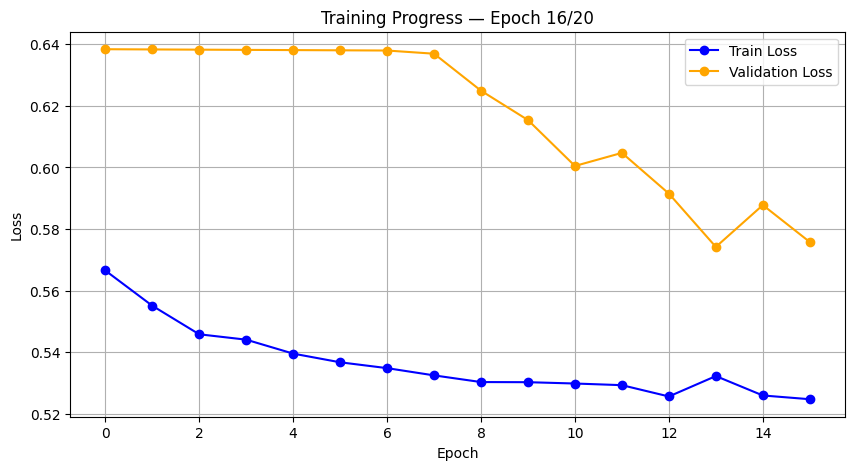

Epoch 16/20 | Train Loss: 0.524713 | Val Loss: 0.575763 | Best Val Loss: 0.574177
Early stopping triggered.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = DiceLoss(mode='binary')

train_losses_dice, val_losses_dice = train(
    model=model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    optimizer=optimizer,
    device=device,
    loss_func=loss_fn,
    num_epochs=20,
    patience=2,
    best_model_path="best_segnet_dice.pth"
)

In [ ]:
model = SegNet(in_channels=3, out_channels=1)

# Запускаем тест
test_loss_dice, test_iou_dice = test(model, test_dataloader, device, loss_func=DiceLoss(mode='binary'),checkpoint_path='best_segnet_dice.pth')
print(f"Test IOU: {test_iou_dice:.6f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test IOU: 0.333638


### SegNet на Focal Loss

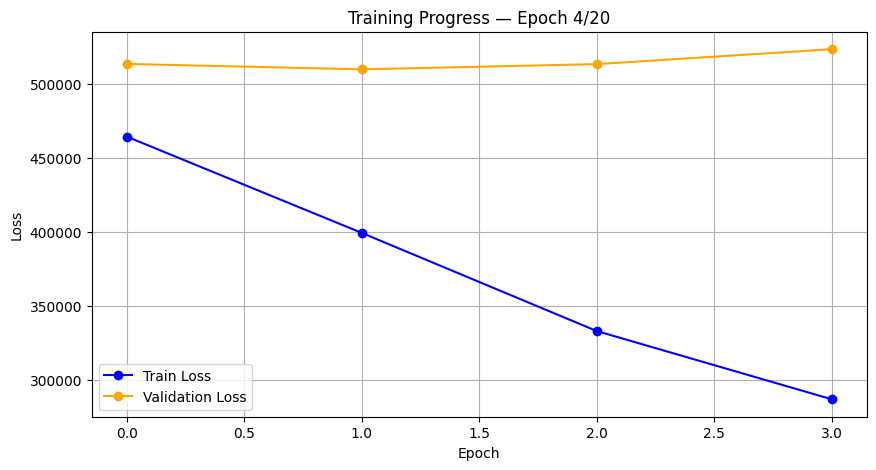

Epoch 4/20 | Train Loss: 287244.210938 | Val Loss: 523708.156250 | Best Val Loss: 510116.062500
Early stopping triggered.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = focal_loss

train_losses_focal, val_losses_focal = train(
    model=model,
    train_loader=train_dataloader,
    valid_loader=valid_dataloader,
    optimizer=optimizer,
    device=device,
    loss_func=loss_fn,
    num_epochs=20,
    patience=2,
    best_model_path="best_segnet_focal.pth"
)

In [ ]:
model = SegNet(in_channels=3, out_channels=1)

# Запускаем тест
test_loss_focal, test_iou_focal = test(model, test_dataloader, device, loss_func=focal_loss,checkpoint_path='best_segnet_focal.pth')
print(f"Test IOU: {test_iou_focal:.6f}")

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

Test IOU: 0.327288


### Сравнение лоссов

При **BCE Loss** модель сходится быстрее и выдает наилучшую метрику IOU
- График BCE:
1. Train loss и Val loss плавно снижаются
2. Early stopping сработал на эпохе 17, модель достигла оптимума
3. Сходимость стабильна

- График Dice:
1. Train loss падает, но Val loss скачет возле ~0.58
2. Сходимость нестабильна, есть скачки
3. Модель не дошла до оптимума

- График Focal:
1. Train loss падает, но Val loss > 500_000 - это катастрофически плохо
2. Модель не обучается, потому что градиенты взрываются


**BCE Loss** - Test IOU: 0.717026(первый запуск) 0.376426(второй запуск)

**Dice Loss** - Test IOU: 0.333638

**Focal Loss** - Test IOU: 0.327288

**Почему Dice и Focal Loss дали плохие результаты?**

**Dice Loss** - нестабильный в начале обучения. Он не чувствителен к малым изменениям, если нет пересечения (TP=0). В начале обучения модель часто выдаёт все нули -> Dice = 0 -> Loss = 1. Градиенты получаются слабыми и модель "застревает"

**Focal Loss** - проблема масштаба. На графике обучения наблюдаются аномально высокие значения лосса:
Train Loss ~ 287 000, Val Loss ~ 523 000.

Такой масштаб связан с тем, что при вычислении лосса используется reduction='sum' вместо reduction='mean'. В результате значение лосса представляет собой сумму ошибок по всем пикселям батча, а не их среднее.

**Это приводит к следующим последствиям:**

Градиенты становятся чрезмерно большими,
Обновления весов модели становятся нестабильными,
Оптимизатор не может эффективно минимизировать функцию потерь,
В итоге модель фактически не обучается

**Что стоит изменить:**

1. Фиксировать случайные seed-ы.
Это обеспечит воспроизводимость и позволит сравнивать лоссы объективно.
2. Проводить несколько запусков с разными seed-ами и использовать среднее значение.
3. Использовать reduction='mean' вместо reduction='sum'

# Задание: Новая модель!

## Модель U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

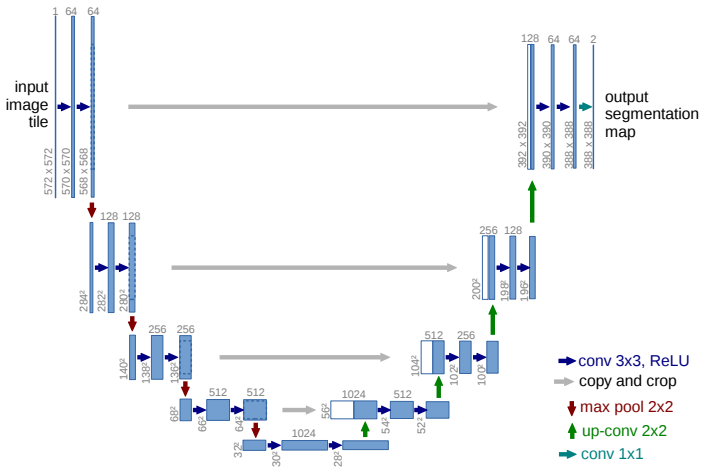

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

В оригинальной статье авторы не использовали padding внутри модели (это видно по тому, что размеры карты признаков уменьшаются на 2 каждый раз при движении от слоя к слою). При этом размеры входных изображений авторы единоразово увеличили при помощи mirror padding.

В этом домашнем задании вы можете применить альтернативный подход - сохранять размеры карт признаков при помощью padding = 1 во внутренних слоях.  

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

Для реализации UNet вы можете написать классы блоков энкодера и декодера отдельно, как мы сделали при реализации SegNet.

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # TODO

    def forward(self, x):
        #  TODO

        return output

In [ ]:
unet_model = UNet().to(device)

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.

